# 🧭 Function 1 Exploration – Capstone Project

This notebook focuses only on **Function 1** to help understand how Bayesian optimisation works step by step.

We’ll:
1. Load and inspect the initial data.
2. Visualise the 2D input–output relationship.
3. Fit a simple **Gaussian Process** surrogate model.
4. Plot its prediction surface and uncertainty.
5. Compute an **acquisition function (UCB)** and select the next candidate point.


In [2]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C

from scipy.stats import norm

sns.set(style="whitegrid")
BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / "initial_data" / "function_1"
assert DATA_DIR.exists(), f"No encuentro {DATA_DIR}"
DATA_DIR

PosixPath('/Users/marvelo/Documents/ImperialCollege/capstone/initial_data/function_1')

Shape X: (13, 2), Shape y: (13,)
y range: -0.003606 → 0.000000, mean: -0.000515, std: 0.001211


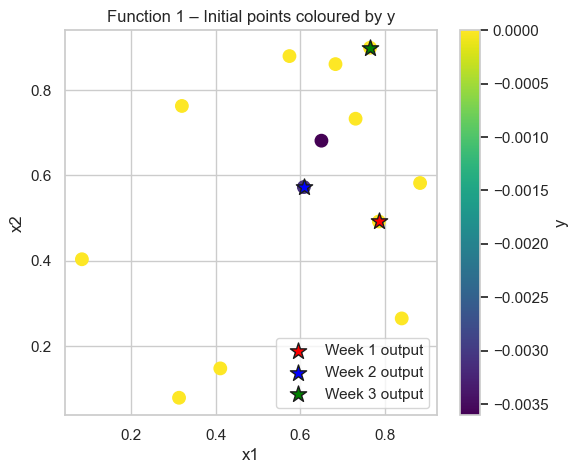

In [3]:
# --- 1. Load data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True)
X = np.array(X, dtype=float)
y = np.array(y, dtype=float).ravel()
week1_inputs = np.array([0.78624237, 0.49210886], dtype=float) 
week1_output = float(8.251611206644282e-31) 

week2_inputs = np.array([0.608457, 0.572782
], dtype=float) 
week2_output = float(-0.0030853359206865424)

week3_inputs = np.array([0.765363, 0.899441], dtype=float) 
week3_output = float(-2.173791662691205e-65) 

X_prev, y_prev = X.copy(), y.copy()
X = np.vstack([X, week1_inputs, week2_inputs, week3_inputs])
y = np.append(y, [week1_output, week2_output, week3_output])

 
print(f"Shape X: {X.shape}, Shape y: {y.shape}")
print(f"y range: {y.min():.6f} → {y.max():.6f}, mean: {y.mean():.6f}, std: {y.std():.6f}")
plt.figure(figsize=(6,5))
sc = plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=80)
plt.scatter(week1_inputs[0], week1_inputs[1],
            c='red', edgecolors='k', s=150, marker='*',
            label='Week 1 output')
plt.scatter(week2_inputs[0], week2_inputs[1],
            c='blue', edgecolors='k', s=150, marker='*',
            label='Week 2 output')
plt.scatter(week3_inputs[0], week3_inputs[1],
            c='green', edgecolors='k', s=150, marker='*',
            label='Week 3 output')
plt.legend(loc='best')
plt.colorbar(sc, label='y')
plt.title('Function 1 – Initial points coloured by y')
plt.xlabel('x1'); plt.ylabel('x2'); plt.show()

### Observations
- We see how the 10 initial points are distributed in the 2D space.
- The colour scale shows which regions have higher or lower values of `y`.
- Our goal will be to find the (x₁, x₂) that maximises `y`.

In [12]:
# --- 2. Fit a Gaussian Process surrogate ---
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C

# --- 2. Fit a robust Gaussian Process surrogate ---
# Kernel: Constant * Matern(ν=2.5) con ARD + WhiteKernel (ruido)
# Bounds más amplios en length_scale para evitar "pegarse" al límite inferior
kernel = (
    C(1.0, (1e-3, 1e3)) *
    Matern(length_scale=[0.3, 0.3], nu=2.5, length_scale_bounds=(0.03, 3.0))
    + WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-6, 1e-2))
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=15,
    random_state=0
)
gp.fit(X, y)
print("Fitted kernel:", gp.kernel_)

Fitted kernel: 0.932**2 * Matern(length_scale=[0.0534, 0.128], nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [20]:
# --- 3. Candidate grid (EXPLORE WIDER) ---
# Explora todo el dominio [0,1]^2 (no solo lo observado)
lb = np.array([0.0, 0.0])
ub = np.array([1.0, 1.0])

# Malla más densa
n = 180
x1 = np.linspace(lb[0], ub[0], n)
x2 = np.linspace(lb[1], ub[1], n)
xx, yy = np.meshgrid(x1, x2)
Xgrid = np.c_[xx.ravel(), yy.ravel()]

# Predicción
mu, sigma = gp.predict(Xgrid, return_std=True)
sigma = np.maximum(sigma, 1e-12)

# --- Acquisition (más exploración) ---
from scipy.stats import norm
y_best = y.max()
xi = 0.10  # ↑ explora
Z = (mu - y_best - xi) / sigma
ei = (mu - y_best - xi) * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma < 1e-12] = 0.0

# Anti-borde y anti-duplicado
edge_eps = 1e-3
mask_edges = (
    (Xgrid[:,0] > edge_eps) & (Xgrid[:,0] < 1 - edge_eps) &
    (Xgrid[:,1] > edge_eps) & (Xgrid[:,1] < 1 - edge_eps)
)
ei_masked = np.where(mask_edges, ei, -np.inf)

def too_close(x, X, tol=0.02):
    return np.any(np.max(np.abs(X - x), axis=1) < tol)

order = np.argsort(-ei_masked)
x_next = None
for idx in order:
    cand = Xgrid[idx]
    if not too_close(cand, X, tol=0.02):
        x_next = cand
        break

print("Suggested next (F1):", x_next)
print("Submission:")
print(f"{x_next[0]:.6f} - {x_next[1]:.6f}")

Suggested next (F1): [0.51396648 0.49162011]
Submission:
0.513966 - 0.491620


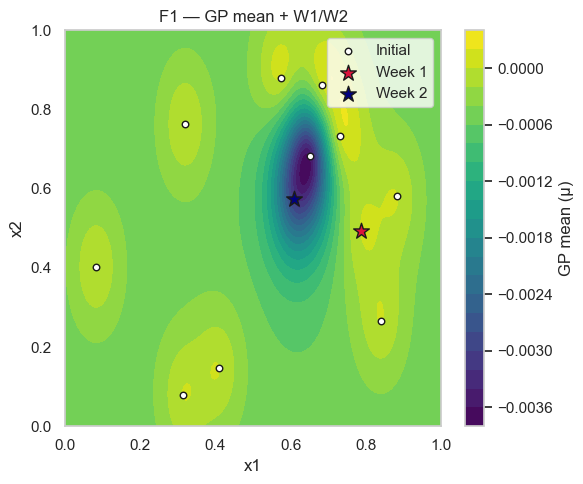

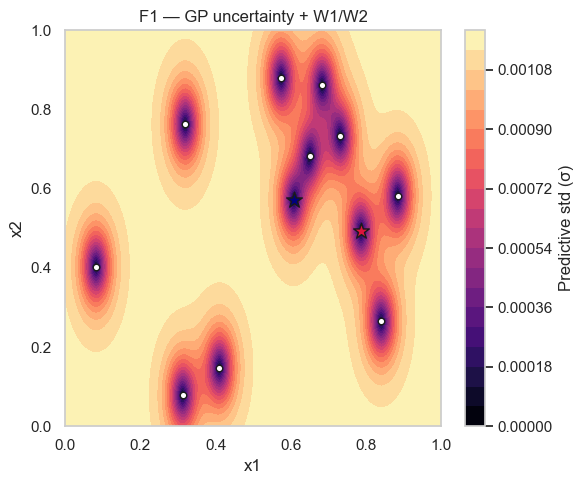

In [21]:
plt.figure(figsize=(6,5))
plt.contourf(xx, yy, mu.reshape(n,n), cmap='viridis', levels=20)
plt.colorbar(label='GP mean (μ)')
plt.scatter(X_prev[:,0], X_prev[:,1], c='w', s=22, edgecolors='k', label='Initial')
plt.scatter(week1_inputs[0], week1_inputs[1], c='crimson', s=140, marker='*', edgecolors='k', label='Week 1')
plt.scatter(week2_inputs[0], week2_inputs[1], c='navy', s=140, marker='*', edgecolors='k', label='Week 2')
plt.title('F1 — GP mean + W1/W2'); plt.xlabel('x1'); plt.ylabel('x2'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,5))
plt.contourf(xx, yy, sigma.reshape(n,n), cmap='magma', levels=20)
plt.colorbar(label='Predictive std (σ)')
plt.scatter(X_prev[:,0], X_prev[:,1], c='w', s=22, edgecolors='k')
plt.scatter(week1_inputs[0], week1_inputs[1], c='crimson', s=140, marker='*', edgecolors='k')
plt.scatter(week2_inputs[0], week2_inputs[1], c='navy', s=140, marker='*', edgecolors='k')
plt.title('F1 — GP uncertainty + W1/W2'); plt.xlabel('x1'); plt.ylabel('x2'); plt.tight_layout(); plt.show()

Now we can see two maps:
- **Prediction surface:** areas the model thinks will give higher `y` values.
- **Uncertainty surface:** areas where the model is less sure (few nearby data points).

In [25]:
from scipy.stats import norm
import numpy as np

# Predicciones en Xgrid (ya las tienes)
mu, sigma = gp.predict(Xgrid, return_std=True)
sigma = np.maximum(sigma, 1e-12)

# --- EI (intento 1) ---
y_best = y.max()       # aquí será ~0.0
xi = 0.10              # explorador, pero puede matar EI si y_best=0
Z = (mu - y_best - xi) / sigma
ei = (mu - y_best - xi) * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma < 1e-12] = 0.0

# Anti-borde
edge_eps = 1e-3
mask_edges = (
    (Xgrid[:,0] > edge_eps) & (Xgrid[:,0] < 1 - edge_eps) &
    (Xgrid[:,1] > edge_eps) & (Xgrid[:,1] < 1 - edge_eps)
)

# Función para elegir candidato con una puntuación dada
def pick_with_score(score, Xgrid, X, tol=0.05):
    score_masked = np.where(mask_edges, score, -np.inf)
    order = np.argsort(-score_masked)
    def too_close_Linf(x, X, tol):
        return np.any(np.max(np.abs(X - x), axis=1) < tol)
    for idx in order:
        cand = Xgrid[idx]
        if not too_close_Linf(cand, X, tol=tol):
            return cand, score_masked[idx]
    # fallback: el mejor aunque esté cerca
    best_idx = np.argmax(score_masked)
    return Xgrid[best_idx], score_masked[best_idx]

# 1) Intento con EI
cand, s = pick_with_score(ei, Xgrid, X, tol=0.05)

# 2) Si EI no tiene señal (todo ≤ 0), usa UCB (más exploración)
if not np.isfinite(s) or s <= 0:
    kappa = 2.5
    ucb = mu + kappa * sigma
    cand, s = pick_with_score(ucb, Xgrid, X, tol=0.05)

# 3) Si aún así está plano, explora por pura incertidumbre (máx σ)
if not np.isfinite(s) or s <= 0:
    cand, s = pick_with_score(sigma, Xgrid, X, tol=0.05)

print("Chosen next (fallback EI→UCB→MaxVar):", cand)
print("Submission format:")
print(f"{cand[0]:.6f} - {cand[1]:.6f}")

Chosen next (fallback EI→UCB→MaxVar): [0.76536313 0.89944134]
Submission format:
0.765363 - 0.899441


In [28]:
import numpy as np
from scipy.stats import norm

# Candidatos de las dos opciones
cand_tr   = np.array([0.765363, 0.899441])  # Opción B (70/30 TR)
cand_free = np.array([0.513966,   0.491620  ])  # Opción sin TR / alternativa

# Helper EI en un punto
def ei_at_point(gp, x, y_best, xi=0.10):
    x = np.asarray(x, float).reshape(1, -1)
    mu_p, sig_p = gp.predict(x, return_std=True)
    sig_p = max(float(sig_p), 1e-12)
    z = (float(mu_p) - y_best - xi) / sig_p
    return (float(mu_p) - y_best - xi) * norm.cdf(z) + sig_p * norm.pdf(z)

y_best = y.max()
ei_tr   = ei_at_point(gp, cand_tr,   y_best, xi=0.10)
ei_free = ei_at_point(gp, cand_free, y_best, xi=0.10)

# Distancias L_inf a puntos ya muestreados (para evitar casi-duplicados)
def too_close_Linf(c, X, tol=0.05):
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

print(f"EI(TR 70/30)   @ {cand_tr}:   {ei_tr:.6e}, near-duplicate? {too_close_Linf(cand_tr, X, 0.05)}")
print(f"EI(No-TR alt.) @ {cand_free}: {ei_free:.6e}, near-duplicate? {too_close_Linf(cand_free, X, 0.05)}")

# Recomendación automática
chosen = cand_tr if ei_tr >= ei_free else cand_free
print("\n>>> Recommended next:", chosen)
print("Submission format:")
print(f"{chosen[0]:.6f} - {chosen[1]:.6f}")

EI(TR 70/30)   @ [0.765363 0.899441]:   0.000000e+00, near-duplicate? False
EI(No-TR alt.) @ [0.513966 0.49162 ]: 0.000000e+00, near-duplicate? False

>>> Recommended next: [0.765363 0.899441]
Submission format:
0.765363 - 0.899441


/var/folders/2y/mzfr093x2cv18ykjgl5dxj7c0000gn/T/ipykernel_58857/1317308710.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sig_p = max(float(sig_p), 1e-12)
/var/folders/2y/mzfr093x2cv18ykjgl5dxj7c0000gn/T/ipykernel_58857/1317308710.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z = (float(mu_p) - y_best - xi) / sig_p
/var/folders/2y/mzfr093x2cv18ykjgl5dxj7c0000gn/T/ipykernel_58857/1317308710.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return (f

✅ **Interpretation:**
- The red X marks the point the UCB function considers most promising.
- You can submit this `(x₁, x₂)` in the required format.
- Record *why* you chose this point: e.g. 'UCB with κ=1.8 to balance exploration near predicted maximum.'

Bitácora (qué escribir esta semana)
	•	Method: GP (Matern 5/2) + WhiteKernel, normalize_y=True
	•	Acquisition: EI (ξ=0.01), candidatos en rango observado con acolchado 10%
	•	Focus: Exploración moderada con mejora esperada (no bordes)
	•	Rationale: Punto con EI máximo, lejos de duplicados, en región con μ alto y σ razonable
	•	Next: Si mejora, la semana que viene afinamos localmente (EI con ξ más bajo, malla local densa)


0.513966 - 0.491620
